In [1]:
import os
import sys
sys.path.insert(0, "../models/multimodal")

In [2]:
import torch
from pathlib import Path
from recommender import ImageRecommender
bin_root = Path("../models/multimodal/bin")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
recommender = ImageRecommender(bin_root/"model_22.pth", bin_root/"embedding.pkl")
recommender.to(device)

In [3]:
import pandas as pd

root = Path("../data")
df = pd.read_csv(root / "flickr8k/captions_test.txt").reset_index(drop=True)
df.head()

,image,caption
0,229951087_4c20600c32.jpg,An older man rows a boat .
1,3535056297_e16f014cb7.jpg,A group of people are looking into the distance .
2,3248220732_0f173fc197.jpg,The skier is leaning forward in the snow .
3,3430100177_5864bf1e73.jpg,Many people are standing outside on a street f...
4,2189995738_352607a63b.jpg,Children are playing and swimming in a boy of ...


In [204]:
images= df["image"]
images.head()

0     229951087_4c20600c32.jpg
1    3535056297_e16f014cb7.jpg
2    3248220732_0f173fc197.jpg
3    3430100177_5864bf1e73.jpg
4    2189995738_352607a63b.jpg
Name: image, dtype: object

In [5]:
captions = df["caption"]
captions.head()

0                           An older man rows a boat .
1    A group of people are looking into the distance .
2           The skier is leaning forward in the snow .
3    Many people are standing outside on a street f...
4    Children are playing and swimming in a boy of ...
Name: caption, dtype: object

In [6]:
import numpy as np
from tqdm import tqdm

cap_vecs = np.zeros((len(captions), 1024))
for i, caption in enumerate(tqdm(captions)):
    embd_cap = recommender.vectorizer(caption).unsqueeze(1).to(device)
    cap_vec = recommender.model.forward_cap(embd_cap).to("cpu").detach().numpy()
    cap_vecs[i] = cap_vec

100%|██████████| 1651/1651 [00:01<00:00, 894.51it/s]


In [205]:
from PIL import Image
import torchvision.transforms as transforms
image_path = Path(root / "flickr8k/images")
transform = transforms.Compose([
    transforms.Resize((224,244)),
    transforms.ToTensor()])

images = df["image"].unique()
img_vecs = np.zeros((len(images), 1024))

for i, image in enumerate(tqdm(images)):
    embd_img = transform(Image.open(image_path / image).convert("RGB")).to(device)
    img_vec = recommender.model.forward_cnn(embd_img.unsqueeze(0)).squeeze(0)
    img_vecs[i] = img_vec.to("cpu").detach().numpy()

100%|██████████| 1511/1511 [00:11<00:00, 131.03it/s]


In [312]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

#cap_pca = PCA(n_components=2)
#cap_svd = TruncatedSVD(n_components=2, algorithm="arpack")
cap_sne = TSNE(n_components=2, random_state=0)
#img_pca = PCA(n_components=2)
cap_data = cap_sne.fit_transform(cap_vecs)

In [313]:
X1 = cap_data[:,0]
print(X1.shape)
X2 = cap_data[:,1]
X2.shape

(1651,)


(1651,)

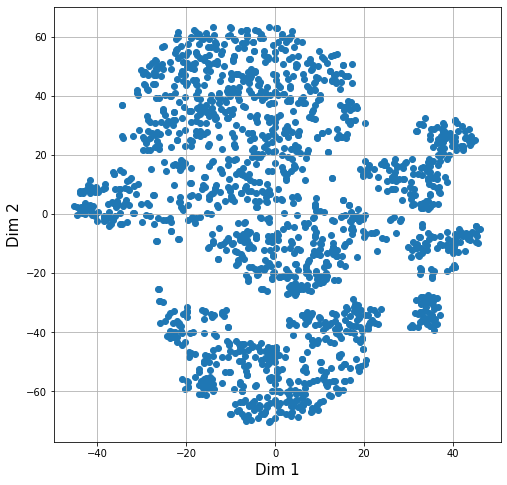

In [314]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Dim 1', fontsize = 15)
ax.set_ylabel('Dim 2', fontsize = 15)
ax.scatter(X1,X2)
ax.grid()

In [315]:
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from sklearn.cluster import AgglomerativeClustering
clustering = DBSCAN(eps=5, min_samples=16).fit(cap_data)

#clustering = AgglomerativeClustering().fit(data)
#clustering = OPTICS(min_samples=6).fit(cap_data)
#clustering = KMeans(n_clusters=8).fit(data)
l = clustering.labels_

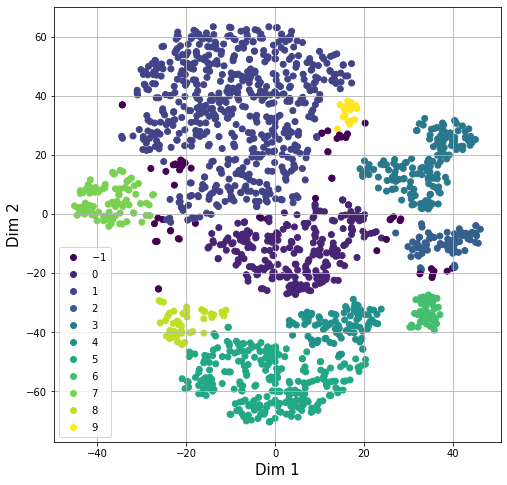

In [316]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
p = (l!=-1)
ax.set_xlabel('Dim 1', fontsize = 15)
ax.set_ylabel('Dim 2', fontsize = 15)
scatter = ax.scatter(X1,X2,c = l)
legend1 = ax.legend(*scatter.legend_elements())
ax.grid()
plt.savefig("tsne_cap.png")

In [317]:
np.unique(l)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [318]:
import spacy
spacy = spacy.load("en")
for k in np.unique(l)[1:]:
    freq_dict = dict()
    for caption in captions[l == k]:
        tokens = [tok.text for tok in spacy.tokenizer(caption.lower())]
        for token in tokens:
            if token in freq_dict:
                freq_dict[token] += 1
            else:
                freq_dict[token] = 1
    items = sorted(freq_dict.items(), key=lambda item: item[1], reverse=True)[:10]
    items = list(map(lambda x: x[0], items))
    print(k, items)

0 ['a', '.', 'the', 'in', 'on', 'water', 'man', 'is', 'boy', 'of']
1 ['a', '.', 'in', 'the', 'on', 'and', 'of', 'with', 'is', 'man']
2 ['a', '.', 'in', 'the', 'on', 'is', 'snow', 'snowboarder', 'of', 'mountain']
3 ['a', '.', 'on', 'the', 'in', 'is', 'man', 'and', 'bike', 'riding']
4 ['a', '.', 'the', 'dog', 'water', 'in', 'dogs', 'on', 'black', 'and']
5 ['a', '.', 'dog', 'the', 'in', 'is', 'black', 'brown', 'and', 'white']
6 ['a', 'snow', 'in', '.', 'the', 'dog', 'black', 'dogs', 'two', 'and']
7 ['a', '.', 'the', 'in', 'player', 'ball', 'is', 'and', 'to', 'football']
8 ['a', '.', 'dog', 'in', 'is', 'and', 'man', 'with', 'boy', 'at']
9 ['a', '.', 'in', 'man', 'of', 'on', 'subway', ',', 'and', 'car']


In [319]:
captions[l == 9].reset_index(drop=True)

0         Two men on a busy subway , seen from behind ,
1                 A man standing in front of a garage .
2     Many young men with backpacks are clinging to ...
3     A man in a black leather jacket is sleeping in...
4     Someone is pulling a big black bag onto a subw...
5     The man with a gray jacket and red sunglasses ...
6               A man and a woman in front of a train .
7                                A man works on a car .
8     A young boy sits on the lap of a man behind th...
9     Two women , one in a rainbow wig , wave out of...
10    Two children with brown hair in a trunk of a c...
11    The man in a blue shirt is holding a camera ne...
12    Two people sit in shadow in the open back of a...
13                        Young people in a busy arcade
14                       People ride a bus or trolley .
15    A woman in a knit cap and a man in a peacoat s...
16                      Several people sit on a train .
17           A train approaches in a dimly lit s

In [320]:
img_sne = TSNE(n_components=2, random_state=0)
img_data = img_sne.fit_transform(img_vecs)

In [321]:
X1 = img_data[:,0]
print(X1.shape)
X2 = img_data[:,1]
X2.shape

(1511,)


(1511,)

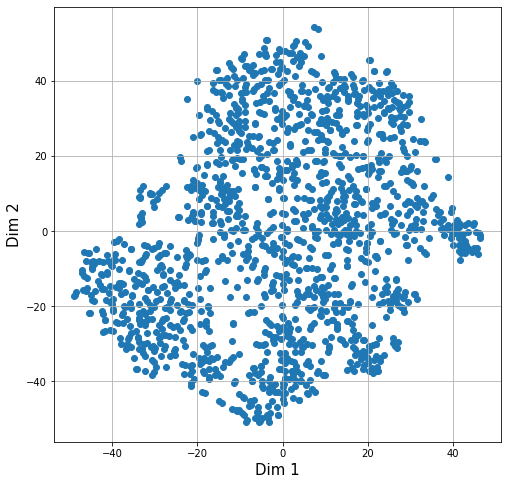

In [322]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Dim 1', fontsize = 15)
ax.set_ylabel('Dim 2', fontsize = 15)
ax.scatter(X1,X2)
ax.grid()

In [375]:
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from sklearn.cluster import AgglomerativeClustering
clustering = DBSCAN(eps=4, min_samples=14).fit(img_data)

#clustering = AgglomerativeClustering().fit(img_data)
#clustering = OPTICS(min_samples=16).fit(img_data)
#clustering = KMeans(n_clusters=10).fit(img_data)
l = clustering.labels_

In [376]:
np.unique(l), len(np.unique(l))

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), 15)

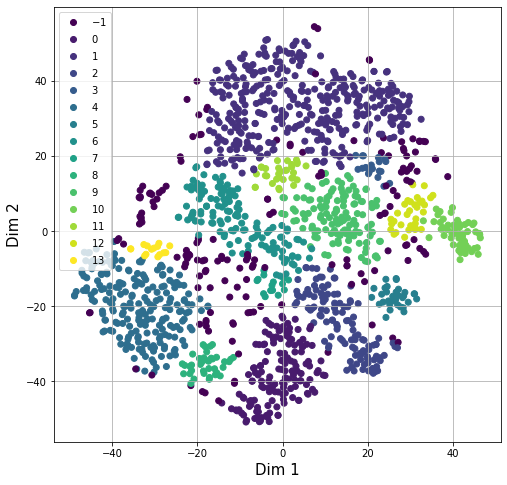

In [377]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
p = (l!=-1)
ax.set_xlabel('Dim 1', fontsize = 15)
ax.set_ylabel('Dim 2', fontsize = 15)
scatter = ax.scatter(X1,X2,c = l)
legend1 = ax.legend(*scatter.legend_elements())
ax.grid()
plt.savefig("tsne_image.png")

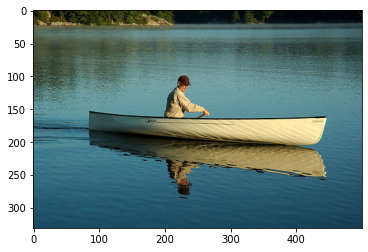

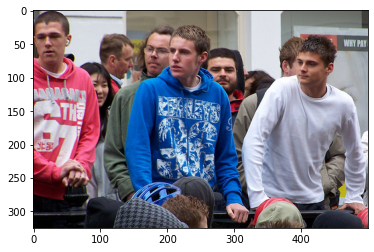

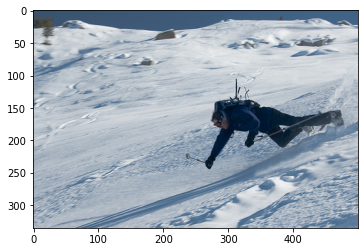

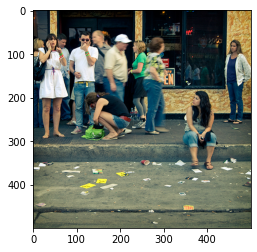

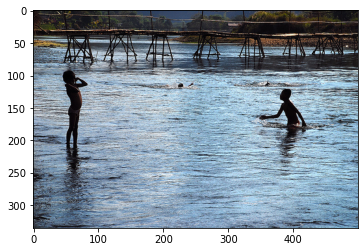

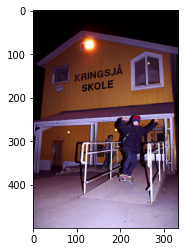

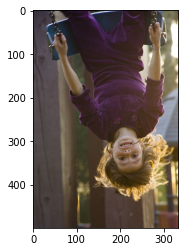

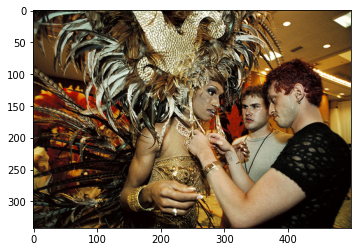

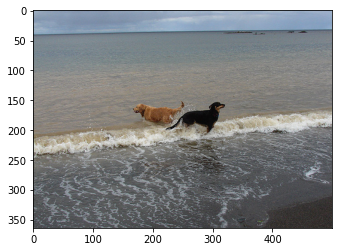

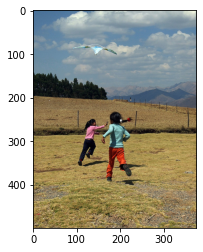

In [371]:
for img in images[l == 0][:10]:
    im = Image.open(image_path / img)
    plt.imshow(im)
    plt.show()

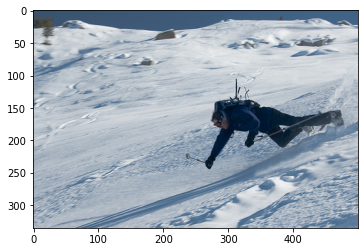

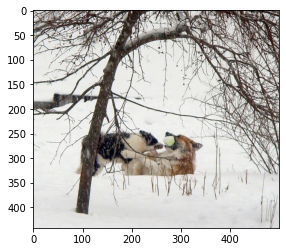

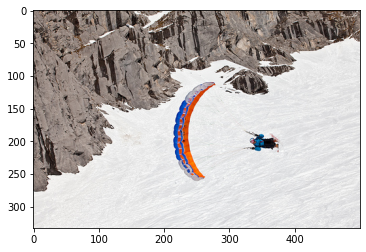

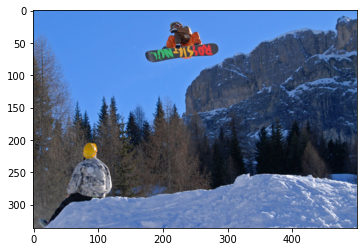

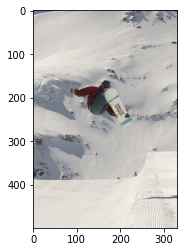

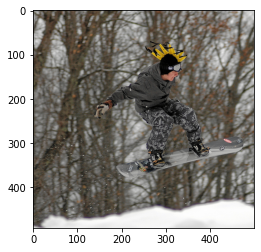

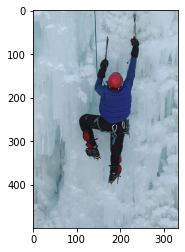

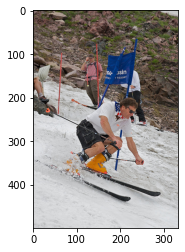

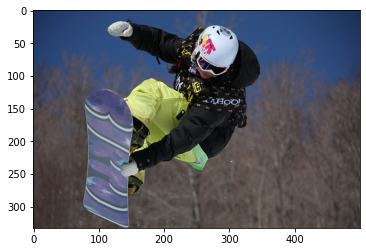

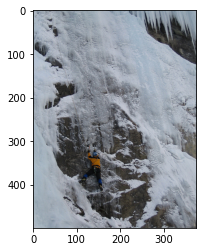

In [329]:
for img in images[l == 1][:10]:
    im = Image.open(image_path / img)
    plt.imshow(im)
    plt.show()